# Partly independent model with probability distribution prediction

One shared MLP and 22 independent models (11 for mean and 11 for standard deviation)

In [1]:
import json

from inverse_problem.nn_inversion.main import HyperParams, Model
from inverse_problem.nn_inversion.posthoc import compute_metrics, open_param_file, plot_params

from pprint import pprint
from astropy.io import fits

### Load data

In [2]:
refer_path = '../data/reference.fits'
refer, names = open_param_file(refer_path)

In [3]:
path_to_json = '../res_experiments/hps_partly_independent_dist_mlp.json'
with open(path_to_json) as f:
    json_data = json.load(f)
    pprint(json_data)

{'activation': 'elu',
 'batch_norm': True,
 'batch_size': 128,
 'bottom_net': 'BottomMLPNet',
 'bottom_output': 100,
 'cont_scale': 40000,
 'dropout': 0.05,
 'factors': [1, 1000, 1000, 1000],
 'hidden_dims': [100, 100],
 'hps_name': 'hps_partly_independent_dist_mlp',
 'logB': True,
 'n_epochs': 5,
 'n_input': 224,
 'predict_ind': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 'source': 'database',
 'top_layers': 2,
 'top_net': 'TopIndependentDistributionNet',
 'top_output': 11,
 'trainset': None,
 'transform_type': 'mlp_transform_rescale',
 'val_split': 0.01,
 'valset': None}


In [4]:
params = fits.open('../data/small_parameters_base.fits')[0].data

In [12]:
# model hyperparameters
hps = HyperParams.from_file(path_to_json=path_to_json)

## Model training

### Model training on a small part of dataset

In [10]:
# hps.n_epochs = 1
model = Model(hps)
# model.net

In [11]:
history = model.train(data_arr=params)

epoch:  20%|██        | 1/5 [00:01<00:06,  1.54s/it]


Epoch 001 train_loss: 11.5535 val_loss 1.0434



epoch:  40%|████      | 2/5 [00:02<00:03,  1.26s/it]


Epoch 002 train_loss: 1.0332 val_loss 1.0245



epoch:  60%|██████    | 3/5 [00:03<00:02,  1.18s/it]


Epoch 003 train_loss: 1.0107 val_loss 0.9982



epoch:  80%|████████  | 4/5 [00:04<00:01,  1.14s/it]


Epoch 004 train_loss: 0.9831 val_loss 0.9734



epoch: 100%|██████████| 5/5 [00:05<00:00,  1.17s/it]


Epoch 005 train_loss: 0.9537 val_loss 0.9404


In [12]:
predicted_common = model.predict_refer('../data/reference.fits')

100%|██████████| 248/248 [00:32<00:00,  7.55it/s]


In [13]:
df_ind = compute_metrics(refer, predicted_common, names)
df_ind

,r2,mse,mae
Field_Strength,0.198,0.110,0.307
Field_Inclination,0.415,0.326,0.557
Field_Azimuth,0.000,0.137,0.307
Doppler_Width,0.004,0.026,0.113
Damping,0.148,0.145,0.241
Line_Strength,0.010,0.054,0.135
Original_Continuum_Intensity,0.176,0.288,0.525
Source_Function_Gradient,0.110,0.077,0.249
Doppler_Shift2,0.000,0.109,0.319
Stray_Light_Fill_Factor,0.239,0.234,0.418


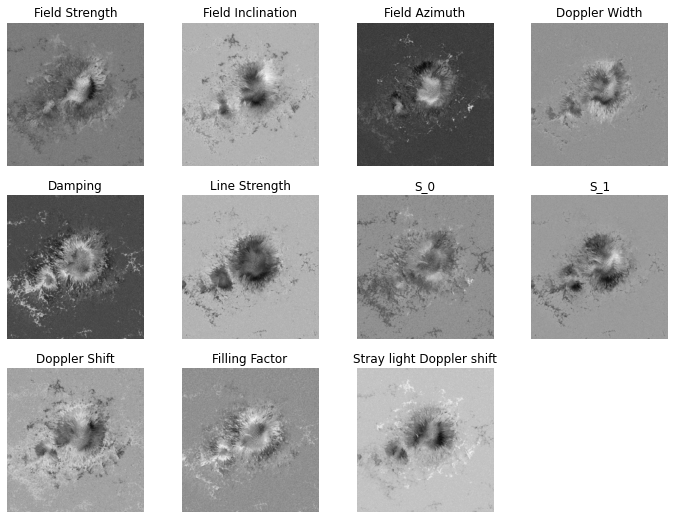

In [11]:
plot_params(predicted_common)

### Model training on the entire dataset

In [5]:
params_full = fits.open('../data/parameters_base.fits')[0].data

In [13]:
full_model = Model(hps)

In [14]:
print("Number of training parameters:", sum(p.numel() for p in full_model.net.parameters() if p.requires_grad))

Number of training parameters: 641766


In [15]:

history = full_model.train(
    data_arr=params_full[:10000],
    logdir = '../logs/',
    path_to_save='../models/pi_dist_mlp2.pt')

epoch:  20%|██        | 1/5 [00:20<01:23, 20.98s/it]


Epoch 001 train_loss: 13.5900 val_loss 1.3460



epoch:  40%|████      | 2/5 [00:38<00:57, 19.04s/it]


Epoch 002 train_loss: 0.8119 val_loss 0.4249



epoch:  60%|██████    | 3/5 [00:56<00:37, 18.51s/it]


Epoch 003 train_loss: 0.3809 val_loss 0.2754



epoch:  80%|████████  | 4/5 [01:13<00:17, 17.90s/it]


Epoch 004 train_loss: 0.2378 val_loss 0.1746



epoch: 100%|██████████| 5/5 [01:30<00:00, 18.12s/it]


Epoch 005 train_loss: 0.1390 val_loss 0.1399


### Loading the trained model

In [16]:
full_model.load_model('../models/pi_dist_mlp_2.pt')

In [17]:
full_predicted_common = full_model.predict_refer('../data/reference.fits')

100%|██████████| 248/248 [00:32<00:00,  7.54it/s]


In [19]:
full_df_ind = compute_metrics(refer, full_predicted_common, names, save_path = '../pi_dist_pred_2.csv')
full_df_ind

,r2,mse,mae
Field_Strength,0.899,0.002,0.025
Field_Inclination,0.893,0.003,0.023
Field_Azimuth,0.610,0.028,0.090
Doppler_Width,0.931,0.001,0.022
Damping,0.905,0.002,0.026
Line_Strength,0.549,0.009,0.042
Original_Continuum_Intensity,0.972,0.000,0.017
Source_Function_Gradient,0.986,0.000,0.011
Doppler_Shift2,0.870,0.000,0.009
Stray_Light_Fill_Factor,0.838,0.012,0.077


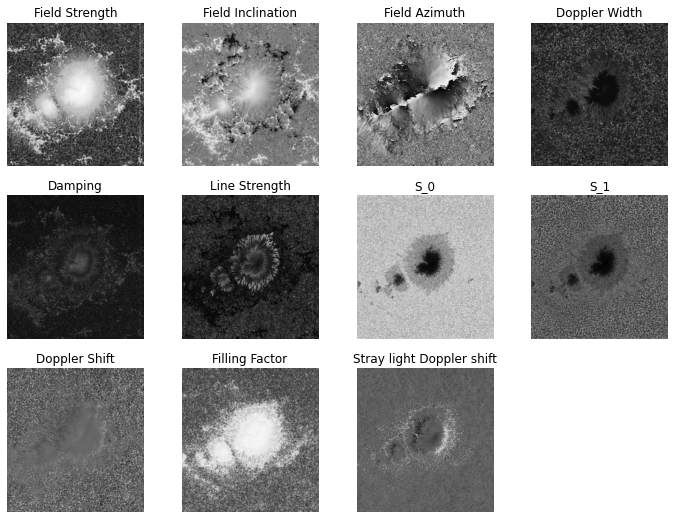

In [20]:
plot_params(full_predicted_common)